In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [2]:
np.random.seed(1908)

# Data loading & preprocessing

In [3]:
goodwares_filenames = os.listdir('./windows_samples/goodwares')
malwares_filenames = os.listdir('./windows_samples/malwares')

In [4]:
len(goodwares_filenames), len(malwares_filenames)

(4290, 1419)

In [5]:
goodware_bytes = []
malware_bytes = []
for i in range(len(goodwares_filenames)):
    with open('./windows_samples/goodwares/' + goodwares_filenames[i], 'rb') as f:
        goodware_bytes.append(np.frombuffer(f.read(), dtype=np.uint8))
for i in range(len(malwares_filenames)):
    with open('./windows_samples/malwares/' + malwares_filenames[i], 'rb') as f:
        malware_bytes.append(np.frombuffer(f.read(), dtype=np.uint8))

In [6]:
# df = pd.DataFrame({'bytes': goodware_bytes + malware_bytes, 'label': [0] * len(goodware_bytes) + [1] * len(malware_bytes)})
df = pd.DataFrame({'bytes': goodware_bytes + malware_bytes, 'label': ["goodware"] * len(goodware_bytes) + ["malware"] * len(malware_bytes)})
df = df.sample(frac=1).reset_index(drop=True)
df

,bytes,label
0,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, ...",goodware
1,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, ...",malware
2,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, ...",malware
3,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, ...",malware
4,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, ...",goodware
...,...,...
5704,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, ...",goodware
5705,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, ...",goodware
5706,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, ...",goodware
5707,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, ...",goodware


In [7]:
df['length'] = df['bytes'].apply(lambda x: len(x))

In [8]:
# train/dev split
# 0.8/0.2
train_df = df[:int(len(df) * 0.8)]
dev_df = df[int(len(df) * 0.8):]

# Data analysis

In [9]:
# print ratio of goodwares/malwares for each dataset
print('train:', len(train_df[train_df['label'] == "goodware"]) / len(train_df[train_df['label'] == "malware"]))
print('dev:', len(dev_df[dev_df['label'] == "goodware"]) / len(dev_df[dev_df['label'] == "malware"]))

train: 3.066785396260018
dev: 2.858108108108108


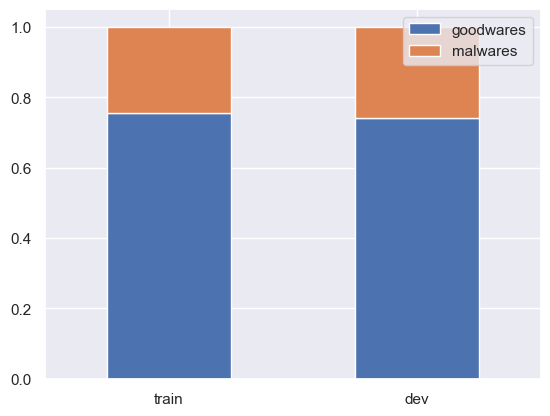

In [10]:
# plot number of goodwares/malwares for each dataset in a stacked bar chart. set on x axis, number of samples on y axis
train_proportions = train_df['label'].value_counts(normalize=True)
dev_proportions = dev_df['label'].value_counts(normalize=True)
# test_proportions = test_df['label'].value_counts(normalize=True)

data = {
    'goodwares': [train_proportions[0], dev_proportions[0]],
    'malwares': [train_proportions[1], dev_proportions[1]]
}
prop_df = pd.DataFrame(data=data, index=['train', 'dev'])

sns.set()
prop_df.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
plt.show()

Text(0.5, 1.0, 'Dev set')

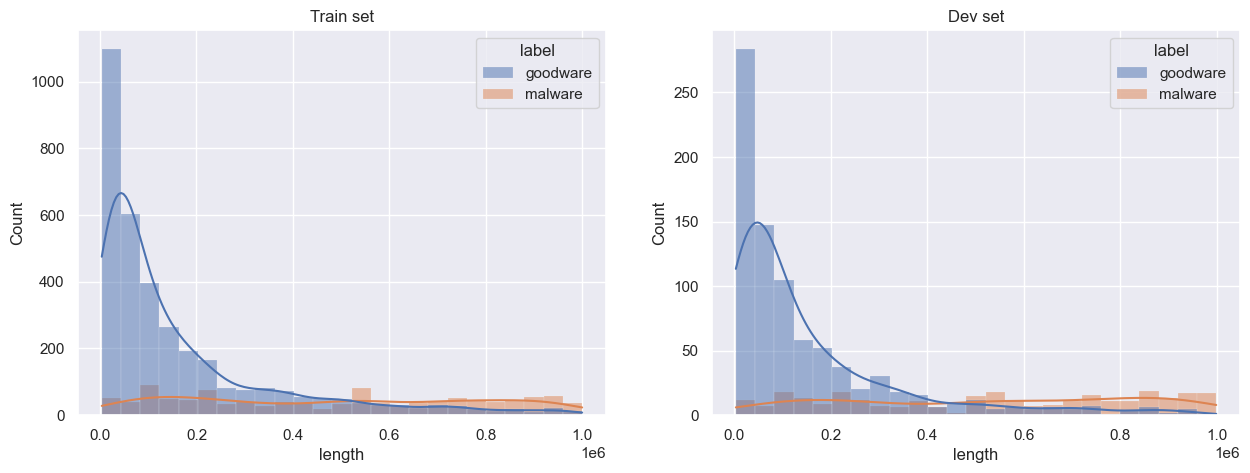

In [11]:
# plot length distribution with first class (goodwares) in blue and second class (malwares) in red
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df, x='length', hue='label', kde=True, bins=25, linewidth=0.1, hue_order=['goodware', 'malware'])
plt.title('Train set')
plt.subplot(1, 2, 2)
sns.histplot(dev_df, x='length', hue='label', kde=True, bins=25, linewidth=0.1, hue_order=['goodware', 'malware'])
plt.title('Dev set')

# Dumb attempt at classification: histogram of bytes

In [12]:
def entropy(histogram):
    total = sum(histogram)
    entropy = 0
    for i in range(256):
        if histogram[i] > 0:
            entropy -= (histogram[i] / total) * np.log2(histogram[i] / total)
    return entropy

In [13]:
def preproc(df):
    bytehist = df["bytes"].apply(lambda x: np.histogram(x, bins=256)[0])
    X = np.stack(bytehist)
    y = df["label"].values
    return X, y

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report
from sklearn.tree import plot_tree

print("Preprocessing train set...")
X_train, y_train = preproc(train_df)
print(X_train.shape, y_train.shape)

print("Preprocessing dev set...")
X_dev, y_dev = preproc(dev_df)
print(X_dev.shape, y_dev.shape)

Preprocessing train set...
(4567, 256) (4567,)
Preprocessing dev set...
(1142, 256) (1142,)


In [15]:

# clf = LogisticRegression(random_state=1908).fit(X_train, y_train)
# clf = SVC(random_state=1908, kernel='linear').fit(X_train, y_train)
# clf = GaussianNB().fit(X_train, y_train)
clf = HistGradientBoostingClassifier(
    random_state=1908,
    # verbose=1,
    max_iter=1000
).fit(X_train, y_train)
# clf = DecisionTreeClassifier(random_state=1908).fit(X_train, y_train)


y_pred = clf.predict(X_dev)
print(classification_report(y_dev, y_pred, labels=["goodware", "malware"]))

              precision    recall  f1-score   support

    goodware       0.98      0.99      0.98       846
     malware       0.96      0.93      0.95       296

    accuracy                           0.97      1142
   macro avg       0.97      0.96      0.96      1142
weighted avg       0.97      0.97      0.97      1142



> Precision: how many of the binary we classified as malicious are actually malicious (how much we got right)

> Recall: how many of the malicious binaries we classified as malicious (how much we missed)

In [16]:
y_pred_train = clf.predict(X_train)
print(classification_report(y_train, y_pred_train, labels=["goodware", "malware"]))

              precision    recall  f1-score   support

    goodware       1.00      1.00      1.00      3444
     malware       1.00      1.00      1.00      1123

    accuracy                           1.00      4567
   macro avg       1.00      1.00      1.00      4567
weighted avg       1.00      1.00      1.00      4567



In [67]:
import pickle

# find all files starting with "model" in the current directory
model_filenames = [filename for filename in os.listdir('.') if filename.startswith('model')]

# if none, set the filename to "model_0.pkl"
if len(model_filenames) == 0:
    model_filename = 'model_0.pkl'
else:
    # find the largest number in the filenames
    model_filename = max(model_filenames, key=lambda x: int(x.split('_')[1].split('.')[0]))
    # increment the number by 1
    model_filename = 'model_' + str(int(model_filename.split('_')[1].split('.')[0]) + 1) + '.pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(clf, f)

In [68]:
# plt.figure(figsize=(70, 50))
# plot_tree(
#     clf,
#     fontsize=10,
#     filled=True,
#     feature_names=[hex(i) for i in range(256)],
#     class_names=["goodware", "malware"],
#     impurity=False,
#     proportion=True,
# )
# plt.show()

In [69]:
# coefs = clf.coef_.reshape(16, 16)

# # rescale coefficients to be in [0, 1]
# coefs = (coefs - coefs.min()) / (coefs.max() - coefs.min())

# # x and y axis are 0 to 9 then A to F
# xlabels = [str(i) for i in range(10)] + [chr(i) for i in range(ord('A'), ord('G'))]
# ylabels = xlabels

# # show logistic regression coefficients
# plt.figure(figsize=(10, 10))
# sns.heatmap(coefs, xticklabels=xlabels, yticklabels=ylabels, cmap='RdBu', center=0, annot=True, fmt='.2f', linewidths=0.1)
# plt.title('Normalized logistic regression coefficients for each byte')

---

In [79]:
# get dev data for goodware and malware separately
X_dev_goodware = X_dev[y_dev == "goodware"]
X_dev_malware = X_dev[y_dev == "malware"]

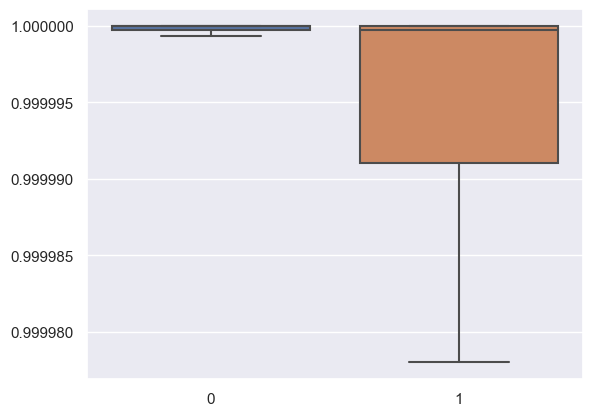

In [80]:
confidence_goodware = clf.predict_proba(X_dev_goodware)[:,0]
confidence_malware = clf.predict_proba(X_dev_malware)[:,1]


from matplotlib.ticker import ScalarFormatter

sns.boxplot(data=[confidence_goodware, confidence_malware], showfliers=False)
ax = plt.gca()
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)

plt.show()

---

In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

In [82]:
# plot PCA with plotly
import plotly.express as px

fig = px.scatter_3d(x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2], color=y_train)
fig.show()

---

# The Malware Repo test

In [83]:
fps = get_file_paths('./The-MALWARE-Repo')
fps = [x[19:] for x in fps]

filesbytes = []
for i in range(len(fps)):
    with open('./The-MALWARE-Repo/' + fps[i], 'rb') as f:
        filesbytes.append(np.frombuffer(f.read(), dtype=np.uint8))

filehists = [np.histogram(x, bins=256)[0] for x in filesbytes]
# entropies = [entropy(x) for x in filehists]
X = np.stack(filehists)
# X = np.hstack([np.stack(filehists), np.array(entropies).reshape(-1, 1)])

preds = clf.predict(X)
probas = clf.predict_proba(X)[:,1]

resdf = pd.DataFrame({'file': fps, 'malware_proba': probas})
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.6f}'.format
resdf

,file,malware_proba
0,README.md,0.014487
1,Net-Worm/Opaserv.l.exe,0.003290
2,Net-Worm/EternalRocks.exe,0.999970
3,Net-Worm/Loveware.txt,0.014714
4,Net-Worm/CodeRed.a.exe,0.000452
5,Net-Worm/Sasser/Sasser.B.exe,0.000005
6,Net-Worm/Sasser/Sasser.c.sourcecode.txt,0.011159
7,Net-Worm/Sasser/Sasser.A.exe,0.000003
8,Net-Worm/Rahack/Rahack.exe,0.999380
9,Net-Worm/Kolabc/Kobalc.exe,0.999235


In [84]:
pd.set_option('display.max_rows', 230)
resdf

,file,malware_proba
0,README.md,0.014487
1,Net-Worm/Opaserv.l.exe,0.003290
2,Net-Worm/EternalRocks.exe,0.999970
3,Net-Worm/Loveware.txt,0.014714
4,Net-Worm/CodeRed.a.exe,0.000452
5,Net-Worm/Sasser/Sasser.B.exe,0.000005
6,Net-Worm/Sasser/Sasser.c.sourcecode.txt,0.011159
7,Net-Worm/Sasser/Sasser.A.exe,0.000003
8,Net-Worm/Rahack/Rahack.exe,0.999380
9,Net-Worm/Kolabc/Kobalc.exe,0.999235


In [85]:
resdf.to_csv('malware_proba.csv', index=False, sep='\t')

---

In [86]:
X_train_goodware = X_train[y_train == "goodware"]
X_train_malware = X_train[y_train == "malware"]

In [87]:
goodware_entropies = np.array([entropy(x) for x in X_train_goodware])
malware_entropies = np.array([entropy(x) for x in X_train_malware])

In [88]:
goodware_entropies.mean(), np.median(goodware_entropies)

(5.988230558423567, 6.115802301395995)

In [89]:
malware_entropies.mean(), np.median(malware_entropies)

(6.818011673785681, 7.136106935775902)

---

In [90]:
devprobas = clf.predict_proba(X_dev)[:, 1]
deventropies = np.array([entropy(x) for x in X_dev])

In [91]:
# compute correlation between entropy and malware probability
from scipy.stats import pearsonr

pearsonr(deventropies, devprobas)

PearsonRResult(statistic=0.5219526131892316, pvalue=8.352888650616728e-81)

---

In [92]:
# only entropy model

trainentropies = np.array([entropy(x) for x in X_train]).reshape(-1, 1)

# entropyclf = LogisticRegression(random_state=1908)
entropyclf = HistGradientBoostingClassifier(
    random_state=1908,
    max_iter=1000
)
entropyclf.fit(trainentropies, y_train)


HistGradientBoostingClassifier(max_iter=1000, random_state=1908)

In [93]:
devpreds = entropyclf.predict(deventropies.reshape(-1, 1))
print(classification_report(devpreds, y_dev))

              precision    recall  f1-score   support

    goodware       0.96      0.89      0.92       916
     malware       0.65      0.85      0.73       226

    accuracy                           0.88      1142
   macro avg       0.80      0.87      0.83      1142
weighted avg       0.90      0.88      0.88      1142



---

In [94]:
train_df["entropy"] = [entropy(x) for x in X_train]
train_df

/tmp/ipykernel_2976/1901212107.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,bytes,label,length,entropy
0,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, 255, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, ...",goodware,176640,5.799248
1,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, 255, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, ...",malware,124928,6.609813
2,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, 255, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, ...",malware,826368,6.276933
3,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, 255, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, ...",malware,700935,6.867584
4,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, 255, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, ...",goodware,411648,6.668774
...,...,...,...,...
4562,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, 255, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, ...",goodware,203776,6.307855
4563,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, 255, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, ...",goodware,192512,6.229117
4564,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, 255, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, ...",malware,627712,3.915086
4565,"[77, 90, 144, 0, 3, 0, 0, 0, 4, 0, 0, 0, 255, 255, 0, 0, 184, 0, 0, 0, 0, 0, 0, 0, 64, 0, 0, 0, ...",goodware,118570,5.630304


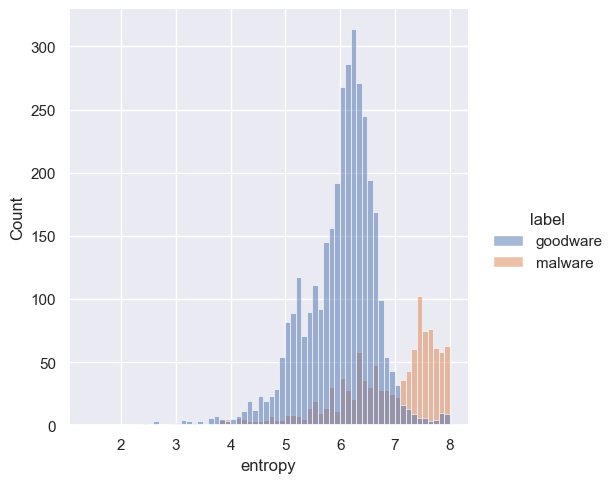

In [95]:
sns.displot(train_df, x="entropy", hue="label")
plt.show()

---

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X_dev, y_dev, n_repeats=10, random_state=1908, n_jobs=-1)

In [ ]:
importances = result['importances_mean']
importances_normalized = (importances / np.sum(importances)) * 100

# Reshape into 16x16 matrix
importances_matrix = importances_normalized.reshape(16, 16)

# Create a DataFrame
df_importances = pd.DataFrame(importances_matrix, 
                              columns=[f'{i:X}' for i in range(16)], 
                              index=[f'{i:X}' for i in range(16)])

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(df_importances, annot=True, fmt=".2f", cmap="viridis")
plt.title('Byte Importance in 16x16 Matrix')
plt.xlabel('Byte Value (Hexadecimal)')
plt.ylabel('Byte Value (Hexadecimal)')
plt.show()


In [ ]:
preds = clf.predict(X_dev)
print(classification_report(preds, y_dev))

---

In [98]:
with open("paint.net.5.0.11.install.anycpu.web.exe", 'rb') as f:
    bytes_ = np.frombuffer(f.read(), dtype=np.uint8)

hist = np.histogram(bytes_, bins=256)[0]
entropy_ = entropy(hist)
entropy_

7.380109802566126